# Evaluación de modelos
En este notebook están agrupados los procedimientos por los cuales se evaluaron algunos modelos de Machine Learning con las reviews lemmatizadas y stemmatizadas y valores predefinidos de hiperparámetros. 

**Los resultados y las conclusiones** de dicho análisis están detallados en el archivo: `Comparacion_lemma_stem.pdf`.

De esta forma se ahorra tiempo en la ejecución del notebook principal del proyecto.

### Importar las librerías necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Garbage collector para optimizar recursos
import gc

# Clase para personalizar las impresiones de consola
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

#### Importamos librerías SpaCy y NLTK

Para el tratamiento de texto, las librerías que nos brindan las herramientas adecuadas son **SpaCy** y **NLTK**. Dependiendo de lo que se quiera hacer, utilizaremos una o la otra.

In [2]:
import spacy # https://spacy.io/usage/models
nlp = spacy.load('en_core_web_md')

#Stop Words de en_core_news_md
from spacy.lang.en.stop_words import STOP_WORDS
stopwords_spacy = list(STOP_WORDS)

import nltk

#Stop Words de nltk
from nltk.corpus import stopwords
stopwords_nltk = set(stopwords.words('english'))

# Para manejo de resgitros de texto
import re
from nltk.tokenize import RegexpTokenizer

#Constante de signos de puntuación
import string
puntua = string.punctuation + '#...'
excluded_pos = ['SCONJ','CCONJ','NUM','PUNCT','PRON','DET','ADP','AUX','X','PROPN']

## Importamos el dataset
Importamos dataset que será utilizado para *train* y nos quedamos con las columnas relevantes.

<span style='color:red;'>**!! ACLARACIÓN:** En el notebook de <a href='https://github.com/lusalmeron/Acamica-DS-Proyecto-4/blob/main/Procesamiento_de_datasets.ipynb'>"Procesamiento_de_datasets"</a> se muestra el trabajo realizado para llegar a un único dataset filtrado por las columnas relevantes y que contengan también las lemmatizaciones y stemmizaciones de cada review concatenada a su título. **Ése es el set de datos que importamos para ahorrar tiempo de ejecución.**</span>

In [3]:
# Importamos dataset limpio
data = pd.read_csv("data/dataset_clothes_clean.csv")
print("- Cantidad de filas " + color.BOLD + "total" + color.END + " del set:", data.shape[0])
print("- Cantidad de filas " + color.BOLD + "nulas" + color.END + " por columna:")
data.isna().sum()

- Cantidad de filas total del set: 22628
- Cantidad de filas nulas por columna:


class_name      0
clothing_id     0
usr_age         0
review_title    0
review_body     0
rating          0
recommended     0
revs_lemma      0
revs_stem       0
dtype: int64

In [4]:
data.head()

,class_name,clothing_id,usr_age,review_title,review_body,rating,recommended,revs_lemma,revs_stem
0,Intimates,767,33,-,Absolutely wonderful - silky and sexy and comf...,4,1,absolutely wonderful silky sexy comfortable,absolut wonder silki sexi comfort
1,Dresses,1080,34,-,Love this dress! it's sooo pretty. i happene...,5,1,love dress sooo pretty happen find store glad ...,love dress sooo pretti happen find store glad ...
2,Dresses,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,major design flaw high hope dress want work in...,major design flaw high hope dress want work in...
3,Pants,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,favorite buy love love love jumpsuit fun flirt...,favorit buy love love love jumpsuit fun flirti...
4,Blouses,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,flattering shirt shirt flattering adjustable t...,flatter shirt shirt flatter adjust tie perfect...


## Vectorización
### Importar y crear vectorizador

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
max_features=10000 # Determina máximo de palabras que toma para hacer la matriz
min_df = 0.0001 # Toma todas las palabras que tengan este mínimo de frecuencia
ngram_range = (1,1) # (1,1) || (1,2) || (2,2)

tfidf = TfidfVectorizer(max_features=max_features, min_df=min_df,ngram_range=ngram_range)

### Separamos datasets lemma y stem

In [6]:
# Columnas de interés del dataset LEMMA
data.loc[:,('class_name','usr_age','revs_lemma','rating','recommended')].head()

,class_name,usr_age,revs_lemma,rating,recommended
0,Intimates,33,absolutely wonderful silky sexy comfortable,4,1
1,Dresses,34,love dress sooo pretty happen find store glad ...,5,1
2,Dresses,60,major design flaw high hope dress want work in...,3,0
3,Pants,50,favorite buy love love love jumpsuit fun flirt...,5,1
4,Blouses,47,flattering shirt shirt flattering adjustable t...,5,1


In [7]:
# Columnas de interés del dataset STEM
data.loc[:,('class_name','usr_age','revs_stem','rating','recommended')].head()

,class_name,usr_age,revs_stem,rating,recommended
0,Intimates,33,absolut wonder silki sexi comfort,4,1
1,Dresses,34,love dress sooo pretti happen find store glad ...,5,1
2,Dresses,60,major design flaw high hope dress want work in...,3,0
3,Pants,50,favorit buy love love love jumpsuit fun flirti...,5,1
4,Blouses,47,flatter shirt shirt flatter adjust tie perfect...,5,1


Probamos primero con las reviews **lemmatizadas**, pero bien podría cambiarse por las **stemmizadas** comentando y descomentando líneas.

En primera instancia, entrenamos el modelo con sólo las reseñas, pero podría probarse agregar otros atributos si mejora el desempeño.

In [8]:
## LEMMA
list_revs = list(data[('revs_lemma')].values)
recom = data['recommended'].values

## STEM
# list_revs = list(data['revs_stem'].values)
# recom = data['recommended'].values

list_revs[:5]

['absolutely wonderful silky sexy comfortable',
 'love dress sooo pretty happen find store glad order online petite buy petite love length me- hit little knee definitely true midi truly petite',
 'major design flaw high hope dress want work initially order petite small usual size find outrageously small small fact zip reorder petite medium overall half comfortable fit nicely half tight layer somewhat cheap net layer imo major design flaw net layer sew directly zipper',
 'favorite buy love love love jumpsuit fun flirty fabulous time wear great compliment',
 'flattering shirt shirt flattering adjustable tie perfect length wear legging sleeveless pair cardigan love shirt']

### Train-Test split de los datos
Usaremos el 70% para entrenamiento y el 30% para prueba. Luego vectorizaremos cada set por separado para evitar *data leaks*.

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, ytrain, ytest = train_test_split(list_revs,recom,test_size=0.3,random_state=42,stratify=recom)
print("- Tamaño del set de " + color.CYAN + "entrenamiento:" + color.BOLD, len(X_train), color.END)
print("- Tamaño del set de " + color.GREEN + "prueba:" + color.BOLD, len(X_test),color.END)
print("- Algunos " + color.BOLD + "ejemplos" + color.END + " del set de entrenamiento:")
X_train[:5]

- Tamaño del set de entrenamiento: 15839 
- Tamaño del set de prueba: 6789 
- Algunos ejemplos del set de entrenamiento:


['love unusual print cut work get round sway dress look twice big actually shaping help adjust curve sad',
 'love love love dress absolutely layered cloud material amazingly soft comfy',
 'fit perfect sleeve little tight uncomfortably wish little room look picture love shirt super cute comfy get compliment',
 'comfy cute grab pair pant sale glad material soft lightweight-- ideal summer fit loose true size standard pair pant',
 'gorgeous comfy barely rarely find maxi far long extreme prefer barely reach ground oppose rise inch floor example perfect flat sandal try chuckle long try perfect length bodice fit glove average bust size fluctuate generally flat chested prefer conservative sleeveless dress']

### Generación de la matriz

In [10]:
# Ajustamos el vectorizador y transformamos los datos de entrenamiento
matriz_train = tfidf.fit_transform(X_train)
matriz_train

<15839x5245 sparse matrix of type '<class 'numpy.float64'>'
	with 354308 stored elements in Compressed Sparse Row format>

In [11]:
# Vemos las palabras utilizadas (ordenadas alfabéticamente)
all_words = tfidf.get_feature_names()
print("Palabras más usadas:",all_words[:200])

Palabras más usadas: ['00p', '10', '10p', '10th', '12', '12p', '130', '138', '140', '145', '155lb', '16', '1960', '1980', '1st', '20', '20th', '24p', '25', '25p', '26', '27', '27p', '28', '29', '29p', '2nd', '30', '30d', '30dd', '30f', '32', '32a', '32b', '32c', '32d', '32dd', '32ddd', '32e', '32f', '33', '34', '34a', '34aa', '34b', '34c', '34d', '34dd', '34ddd', '34f', '35', '36a', '36b', '36c', '36d', '36dd', '36ddd', '37ish', '38', '38c', '38d', '3rd', '40', '40d', '40th', '4th', '50', '50th', '5ft2', '5th', '60', '60th', '6th', '70', '80', '90', '95lb', 'ab', 'abdomen', 'ability', 'able', 'abo', 'abroad', 'abso', 'absolute', 'absolutely', 'absolutly', 'abstract', 'absurd', 'abt', 'abundance', 'accent', 'accentuate', 'accept', 'acceptable', 'access', 'accessorize', 'accessorizing', 'accessory', 'accident', 'accidental', 'accidentally', 'accommodate', 'accomodate', 'accomplish', 'accord', 'accordingly', 'account', 'accurate', 'accurately', 'achieve', 'ack', 'acrylic', 'act', 'active'

In [12]:
# Transformamos los datos de prueba en base al vectorizador ya entrenado
matriz_test = tfidf.transform(X_test)
matriz_test

<6789x5245 sparse matrix of type '<class 'numpy.float64'>'
	with 150894 stored elements in Compressed Sparse Row format>

## Modelización
Prpobamos distintos modelos para la clasificación.

In [13]:
# Importamos modelos
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

In [14]:
xtrain = matriz_train.toarray()
xtest = matriz_test.toarray()

# Para la validación cruzada neceitamos el set entero
X = tfidf.transform(list_revs)
X = X.toarray()
y = recom
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### Métricas de evluación

In [15]:
from sklearn.metrics import classification_report # Para un reporte con precision, recall y f1_score
from sklearn.metrics import accuracy_score

Vamos a utilizar el **accuracy score** para evaluar en general la precisión del multiclasificador, ya que genera un promedio entre todas las clases (que en nuestro dataset están balancedas en cantidad) y hace un ajuste entre *precisión* y *recall*. 

Como complemento, utilizaremos el **Calssification report** para ver cómo varían la precisión y el recall por clase.

También elaboramos función para visualizar la **matriz de confusión** de cada modelo.

In [16]:
from sklearn.metrics import confusion_matrix

def confusion(ytest,y_pred):
    names=["No Recomendado","Recomendado"]
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(7,7))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

### Validación cruzada

In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

def k_validacion_cruzada(model,x,y,k):
    scores = cross_val_score(model, x, y, cv=k)
    print("%0.2f de precisión con desviación estándar de %0.2f" % (scores.mean(), scores.std()))

### Naive Bayes - Modelo Benchmark

In [19]:
nb = GaussianNB()
nb.fit(X=xtrain,y=ytrain)

y_pred = nb.predict(xtest)
print(color.BOLD + 'Accuracy : ' + color.END, accuracy_score(ytest,y_pred))

Accuracy :  0.41036971571660036


In [26]:
print(color.BOLD + 'Validación cruzada:' + color.END)
k_validacion_cruzada(nb,X,recom,5)

Validación cruzada:
0.40 de precisión con desviación estándar de 0.01


In [21]:
print(color.BOLD + 'Reporte de clasificación : '+ color.END + '\n \n' ,classification_report(ytest, y_pred, target_names=['No Rec','Rec']))

Reporte de clasificación : 
 
               precision    recall  f1-score   support

      No Rec       0.20      0.78      0.32      1230
         Rec       0.87      0.33      0.48      5559

    accuracy                           0.41      6789
   macro avg       0.54      0.56      0.40      6789
weighted avg       0.75      0.41      0.45      6789



*Las métricas del reporte se ven explicadas en la matriz de confusión.*

**Accuracy:** De todos los predichos de una clase, qué porcentaje realmente pertenece a ella.<br>
**Recall:** De todos los que son de una clase, qué porcentaje predijo correctamente.

Matriz de confusión : 


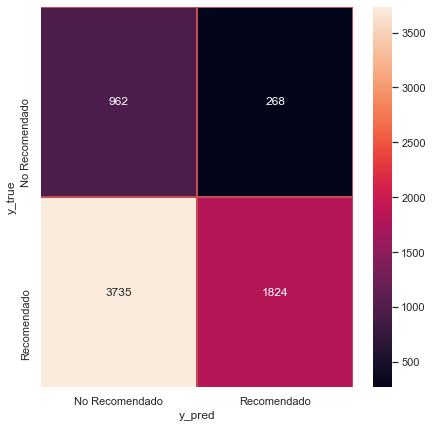

In [28]:
print(color.BOLD + 'Matriz de confusión : '+ color.END)
confusion(ytest,y_pred)

### Random Forest

In [29]:
rf = RandomForestClassifier()
rf.fit(xtrain,ytrain)

y_pred = rf.predict(xtest)
print(color.BOLD + 'Accuracy : ' + color.END, accuracy_score(ytest, y_pred))

Accuracy :  0.8750920606864044


In [30]:
# La validación cruzada demora unos 5 minutos aprox
print(color.BOLD + 'Validación cruzada:' + color.END)
k_validacion_cruzada(rf,X,recom,3) # Se ponen menos folds porque si no demora mucho

Validación cruzada:
0.87 de precisión con desviación estándar de 0.00


In [31]:
print(color.BOLD + 'Reporte de clasificación : '+ color.END + '\n \n' ,classification_report(ytest, y_pred, target_names=['No Rec','Rec']))

Reporte de clasificación : 
 
               precision    recall  f1-score   support

      No Rec       0.84      0.38      0.52      1230
         Rec       0.88      0.98      0.93      5559

    accuracy                           0.88      6789
   macro avg       0.86      0.68      0.73      6789
weighted avg       0.87      0.88      0.86      6789



*Las métricas del reporte se ven explicadas en la matriz de confusión.*

Matriz de confusión : 


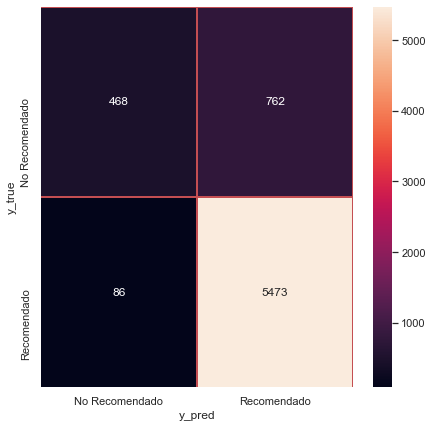

In [32]:
print(color.BOLD + 'Matriz de confusión : '+ color.END)
confusion(ytest,y_pred)

#### Feature importances
Algo muy bueno de Random Forest es que puede indicar la importancia de los features que se usan para clasificar. Veamos en este caso cuáles son las palabras que mayormente determinan el el valor de una review para este clasificador.

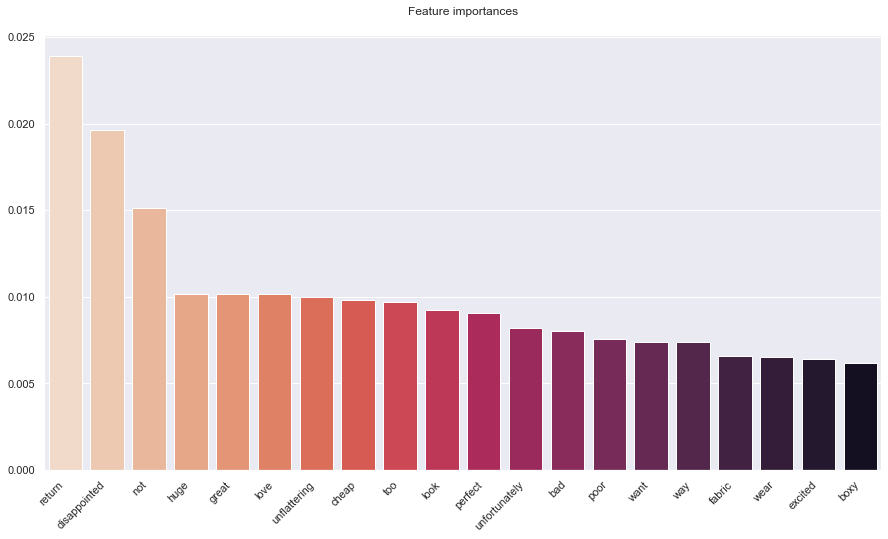

In [33]:
# Le preguntamos la importancia de cada feature (cada palabra)
importances = rf.feature_importances_
# Tomamos la lista de palabras
all_words = tfidf.get_feature_names()
columns = all_words

# Ordenamos por importnacia y tomamos las 20 primeras
indices = np.argsort(importances)[::-1]
indices = indices[:20]
selected_columns = [columns[i] for i in indices] # 
selected_importances = importances[indices] # 

# Por ultimo graficamos
plt.figure(figsize = (15,8))
plt.title(label='Feature importances',pad=20)
grafico = sns.barplot(x=selected_columns, y=selected_importances,palette='rocket_r')
grafico.set_xticklabels(grafico.get_xticklabels(), rotation=45, ha="right")
plt.show()

### SVM

In [27]:
# En vez de utilizar SVC, vamos a usar LinearSVC, 
# ya que para el Kernel Lineal esta función es MUCHO mas rapida que la tradicional SVC.

svc = LinearSVC(C = 1)
svc.fit(xtrain,ytrain)

y_pred = svc.predict(xtest)
print(color.BOLD + 'Accuracy : ' + color.END, accuracy_score(ytest, y_pred))

Accuracy :  0.9019001325673884


In [28]:
print(color.BOLD + 'Validación cruzada:' + color.END)
k_validacion_cruzada(svc,X,recom,5)

Validación cruzada:
0.90 de precisión con desviación estándar de 0.00


In [24]:
print(color.BOLD + 'Reporte de clasificación : '+ color.END + '\n \n' ,classification_report(ytest, y_pred, target_names=['No Rec','Rec']))

Reporte de clasificación : 
 
               precision    recall  f1-score   support

      No Rec       0.77      0.65      0.71      1230
         Rec       0.93      0.96      0.94      5559

    accuracy                           0.90      6789
   macro avg       0.85      0.80      0.82      6789
weighted avg       0.90      0.90      0.90      6789



*Las métricas del reporte se ven explicadas en la matriz de confusión.*

Matriz de confusión : 


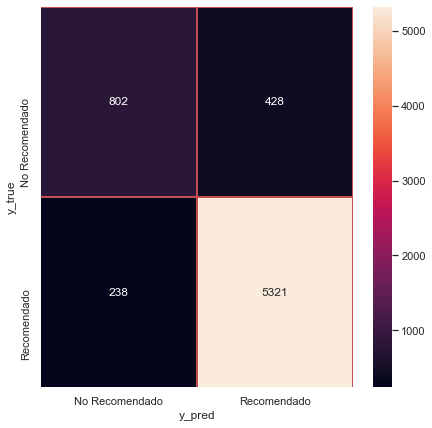

In [37]:
print(color.BOLD + 'Matriz de confusión : '+ color.END)
confusion(ytest,y_pred)

### Comparación modelos `Lemma` vs `Stem`

- El benchmark con el dataset stemmizado es apenas mejor que el dataset lemmatizado cuando se incluyen bigramas: entre 70 y 74% por sobre aprox 40% para sólo monogramas. De todas formas son valores mejorables.
- El Random Forest es parejo con el accuracy con el dataset stemmizado y el lemmatizado. Sin embargo, empeora su recall de la clase no recomendada.
- El SVC, en ambos casos, es el que tiene el mejor rendimiento. Analizando en profundidad, el SVC con el dataset lema tiene mejor precisión y recall en todas las clases.

La comparación más extensiva está en este documento: <https://github.com/lusalmeron/Acamica-DS-Proyecto-4/blob/main/Comparacion_lemma_stem.pdf>

### Conclusión: SVC con dataset lemma y monogramas
Por su rendimiento general y en cada clase en partiuclar, buscaremos optimizar este modelo para aumentar su accuracy.